In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, f1_score

from tqdm import tqdm
from math import log10

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import top_k_accuracy_score
from sklearn.feature_selection import f_classif, f_regression

## Get top 10 features for SDP network + SCIP running time prediction

In [2]:
runtimes = pd.read_excel('C:/Users/Jasmin/Documents/MSc-Thesis/Data/Runtime/Results-MIPVerify_SDPdMLPa.xlsx')
df0 = pd.read_csv('C:/Users/Jasmin/Documents/MSc-Thesis/Feature_Extraction/feature_data_rp/RP_dynamic_dataclean_11.csv')
df0.rename(columns={'SampleNumber': 'INSTANCE_NAME'}, inplace=True)
df0.drop(columns='Unnamed: 0', inplace=True)
df = pd.merge(pd.read_csv('C:/Users/Jasmin/Documents/MSc-Thesis/Feature_Extraction/feature_data_rp/RP_data_08.csv'),
              pd.read_csv('C:/Users/Jasmin/Documents/MSc-Thesis/Feature_Extraction/feature_data_rp/RP_data_09.csv'), on="INSTANCE_NAME")

df['INSTANCE_NAME'] = df['INSTANCE_NAME'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df0['INSTANCE_NAME'] = df0['INSTANCE_NAME'].astype('int')

df = pd.merge(df,df0, on="INSTANCE_NAME")

lp_list = list(df['INSTANCE_NAME'])
runtimes = runtimes.loc[runtimes['SampleNumber'].isin(lp_list)]
df = df.rename(columns={"INSTANCE_NAME": "SampleNumber"})
## Join the two datasets by samplenumber/lp_file
df = pd.merge(df, runtimes, on="SampleNumber")
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df = df.drop(cols_to_drop, axis=1)
df = df.T.drop_duplicates().T
df

,SampleNumber,VARS_presolve_default,BIN_VARS_presolve_default,CONT_VARS_presolve_default,UPPERBOUNDS_MEAN_presolve_default,UPPERBOUNDS_MIN_presolve_default,UPPERBOUNDS_MAX_presolve_default,UPPERBOUNDS_STD_presolve_default,UPPERBOUNDS_MEDIAN_presolve_default,UPPERBOUNDS_DENSITY_presolve_default,...,SolveTime_default,SolveStatus_default,SolveTime_conf1,SolveStatus_conf1,SolveTime_conf2,SolveStatus_conf2,SolveTime_conf3,SolveStatus_conf3,SolveTime_best,Config_best
0,1,1437.0,330.0,1107.0,0.452455,0.0,4.014668,0.208556,0.1,0.999304,...,104.393417,InfeasibleOrUnbounded,152.683291,InfeasibleOrUnbounded,44.068493,Infeasible,78.731996,Infeasible,44.068493,SolveTime_conf2
1,10,1403.0,313.0,1090.0,0.459198,0.0,4.514678,0.241107,0.1,0.996436,...,9600.019248,UserLimit,9600.330209,UserLimit,9600.206703,UserLimit,9600.171495,UserLimit,9600.019248,TIMEOUT
2,100,1399.0,311.0,1088.0,0.432643,0.0,4.140987,0.204747,0.1,0.99857,...,89.865928,InfeasibleOrUnbounded,779.582903,InfeasibleOrUnbounded,80.580781,Infeasible,215.399513,Infeasible,80.580781,SolveTime_conf2
3,1000,1443.0,333.0,1110.0,0.466921,0.0,4.464831,0.221774,0.1,0.999307,...,9600.048013,UserLimit,9600.379411,UserLimit,9600.130473,UserLimit,9600.117678,UserLimit,9600.048013,TIMEOUT
4,10000,1329.0,276.0,1053.0,0.423002,0.003922,3.856785,0.220129,0.1,1.0,...,22.112561,InfeasibleOrUnbounded,378.362607,InfeasibleOrUnbounded,78.919991,Infeasible,18.838446,Infeasible,18.838446,SolveTime_conf3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,1375.0,299.0,1076.0,0.441397,0.0,3.593675,0.207536,0.1,0.999273,...,136.404467,InfeasibleOrUnbounded,169.627541,InfeasibleOrUnbounded,179.118139,Infeasible,200.96392,Infeasible,136.404467,SolveTime_default
9996,9996,1275.0,249.0,1026.0,0.380774,0.0,3.215775,0.189279,0.1,0.904314,...,12.67472,InfeasibleOrUnbounded,18608.097787,UserLimit,25.863838,Infeasible,172.11687,Infeasible,12.67472,SolveTime_default
9997,9997,1379.0,301.0,1078.0,0.418347,0.000135,3.886279,0.207325,0.1,1.0,...,18.37995,InfeasibleOrUnbounded,110.131027,InfeasibleOrUnbounded,50.209194,Infeasible,110.876559,Infeasible,18.37995,SolveTime_default
9998,9998,1365.0,294.0,1071.0,0.430596,0.0,4.26094,0.212202,0.1,0.999267,...,75.684641,InfeasibleOrUnbounded,105.670172,InfeasibleOrUnbounded,106.346014,Infeasible,102.81169,Infeasible,75.684641,SolveTime_default


In [3]:
df['SolveTime_default'][df['SolveTime_default'] >= 9600] = 9600
df['SolveTime_conf1'][df['SolveTime_conf1'] >= 9600] = 9600
df['SolveTime_conf2'][df['SolveTime_conf2'] >= 9600] = 9600
df['SolveTime_conf3'][df['SolveTime_conf3'] >= 9600] = 9600
df['SolveTime_best'][df['SolveTime_best'] >= 9600] = 9600
df.head()

,SampleNumber,VARS_presolve_default,BIN_VARS_presolve_default,CONT_VARS_presolve_default,UPPERBOUNDS_MEAN_presolve_default,UPPERBOUNDS_MIN_presolve_default,UPPERBOUNDS_MAX_presolve_default,UPPERBOUNDS_STD_presolve_default,UPPERBOUNDS_MEDIAN_presolve_default,UPPERBOUNDS_DENSITY_presolve_default,...,SolveTime_default,SolveStatus_default,SolveTime_conf1,SolveStatus_conf1,SolveTime_conf2,SolveStatus_conf2,SolveTime_conf3,SolveStatus_conf3,SolveTime_best,Config_best
0,1,1437.0,330.0,1107.0,0.452455,0.0,4.014668,0.208556,0.1,0.999304,...,104.393417,InfeasibleOrUnbounded,152.683291,InfeasibleOrUnbounded,44.068493,Infeasible,78.731996,Infeasible,44.068493,SolveTime_conf2
1,10,1403.0,313.0,1090.0,0.459198,0.0,4.514678,0.241107,0.1,0.996436,...,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,TIMEOUT
2,100,1399.0,311.0,1088.0,0.432643,0.0,4.140987,0.204747,0.1,0.99857,...,89.865928,InfeasibleOrUnbounded,779.582903,InfeasibleOrUnbounded,80.580781,Infeasible,215.399513,Infeasible,80.580781,SolveTime_conf2
3,1000,1443.0,333.0,1110.0,0.466921,0.0,4.464831,0.221774,0.1,0.999307,...,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,UserLimit,9600,TIMEOUT
4,10000,1329.0,276.0,1053.0,0.423002,0.003922,3.856785,0.220129,0.1,1.0,...,22.112561,InfeasibleOrUnbounded,378.362607,InfeasibleOrUnbounded,78.919991,Infeasible,18.838446,Infeasible,18.838446,SolveTime_conf3


In [4]:

dumb_array = df['SolveTime_default'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))

100%|██████████| 10000/10000 [00:00<00:00, 2261811.91it/s]


In [5]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

mse: 0.4709726740709595
rmse: 0.6862744888679453


,0
LOWERBOUNDS_STD_presolve_default,0.158092
LOWERBOUNDS_MIN_presolve_default,0.082443
LOWERBOUNDS_MIN_presolve_off,0.078680
Gap,0.054891
LP_dualLP_Iter/call,0.036785
BOUNDRANGE_MAX_presolve_default,0.031943
LH_CONSTR_MAX_presolve_default,0.031355
avgswitchlength,0.018030
CONSTR_MAX_presolve_default,0.016169
Separators_gomory_FoundCuts,0.015891


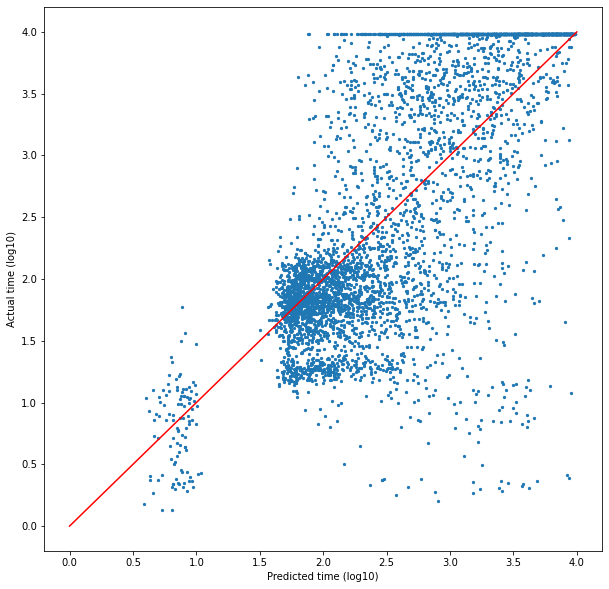

In [30]:
plt.subplots(figsize=(10, 10))
plt.scatter(x=preds, y=testing_labels, s=5)
plt.plot([0,1,2,3,4], color='red') 
plt.xlabel('Predicted time (log10)') 
plt.ylabel('Actual time (log10)')
#plt.title('Running time predictions for Config default with all SCIP features (rmse = ' + str(round(rmse,4)) + ')')
plt.show()

## PCA for running time prediction SCIP features

In [7]:
# import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [41]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = df['SolveTime_default']

x_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pcs = pca.fit_transform(x_scaled)


pcaDF = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])
print(pcaDF)

print(pca.components_)

# ratio of the total variance each principal component captures.
print(sum(pca.explained_variance_ratio_))

dfpca = pd.concat([pcaDF, y], axis = 1)
dfpca

      principal component 1  principal component 2
0                  9.470544              -2.043110
1                  1.133246              -1.882765
2                 -0.879140              -3.122951
3                 15.072628               1.178497
4                -11.979515               0.798095
...                     ...                    ...
9995              -1.582742              -6.134985
9996             -22.246172              -1.523295
9997              -4.738608              -1.250999
9998              -4.300293               0.032528
9999              -1.778231               1.309712

[10000 rows x 2 columns]
[[ 1.07772990e-01  1.07773053e-01  1.07772753e-01  9.82772450e-02
   1.48642471e-03  5.16886150e-02  2.06883451e-02  4.27576571e-03
   2.95544464e-02  7.95031453e-02 -9.29195000e-02 -3.49114684e-04
   8.25819957e-02 -8.16539518e-02  9.19794895e-02 -4.03343336e-03
   9.06123312e-02  5.33102596e-02  5.37811306e-02 -1.07797360e-01
  -1.07797360e-01 -1.07820371e-0

,principal component 1,principal component 2,SolveTime_default
0,9.470544,-2.043110,104.393417
1,1.133246,-1.882765,9600
2,-0.879140,-3.122951,89.865928
3,15.072628,1.178497,9600
4,-11.979515,0.798095,22.112561
...,...,...,...
9995,-1.582742,-6.134985,136.404467
9996,-22.246172,-1.523295,12.67472
9997,-4.738608,-1.250999,18.37995
9998,-4.300293,0.032528,75.684641


In [42]:
modified_dfpca = dfpca.drop(dfpca[dfpca['principal component 2'] > 150].index)

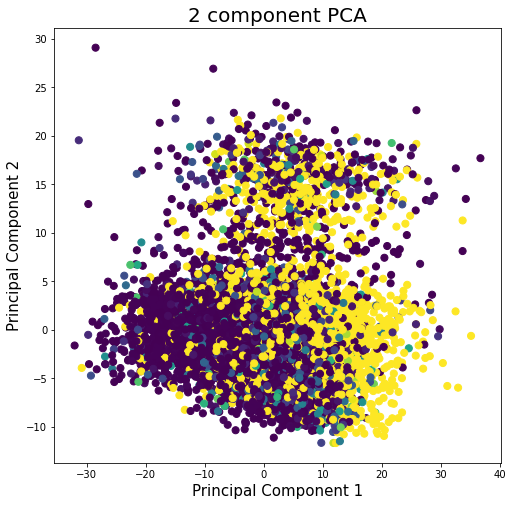

In [46]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


ax.scatter(modified_dfpca['principal component 1'], 
           modified_dfpca['principal component 2'],
             c = modified_dfpca['SolveTime_default'], s = 50)

In [12]:
X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = df['SolveTime_default']
x_scaled = StandardScaler().fit_transform(X)

EVR = []
nlist = []
for n in range(101):
    pca = PCA(n_components=n)
    pca.fit_transform(x_scaled)
    # ratio of the total variance each principal component captures.
    print(sum(pca.explained_variance_ratio_))
    EVR.append(sum(pca.explained_variance_ratio_))
    nlist.append(n)
    

0
0.22608427078536691
0.3187925475620943
0.388917707955864
0.45073350557177366
0.49404794572158184
0.530896310456657
0.5566306755762714
0.580639935368389
0.6013744094147541
0.6202514372038199
0.6354639488438835
0.6498008892058823
0.662520671560715
0.6748541242303588
0.6870068648040156
0.69734297814658
0.7069775578169375
0.716118387629368
0.7243587962565394
0.7324138870400765
0.7402856393259479
0.7473144329481246
0.7541092818924698
0.7607385857818915
0.7671160327467209
0.772882488295311
0.778453981453425
0.7837682321197371
0.7888503797604048
0.7938687350006277
0.7987077409155162
0.8033894315877036
0.8079867719235395
0.812462913346381
0.8168657123431394
0.8211163125399409
0.8245046068884725
0.8288786760649915
0.8327876832488981
0.8369116305930728
0.8407480064563569
0.8445645148373877
0.8482953973695669
0.851857578060837
0.8553404335184954
0.8583883300472837
0.8620701862626399
0.8653034724812435
0.8682422053456811
0.8711789032066866
0.8739738336553503
0.8767329836685891
0.8796927661995906

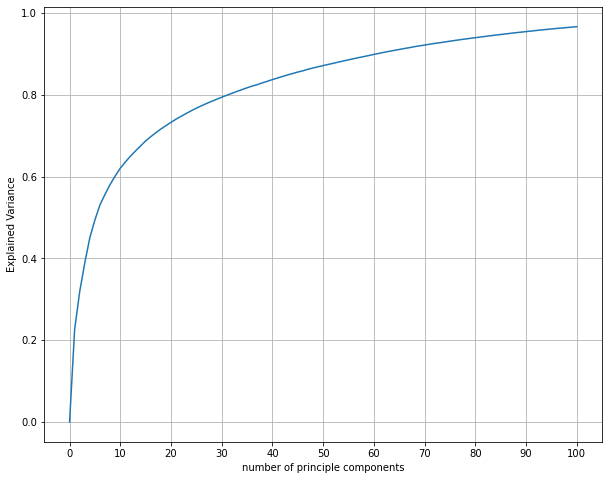

In [27]:
plt.figure(figsize=(10,8))
plt.plot(nlist, EVR)
plt.xticks(np.arange(0, 101, step=10))
plt.xlabel('number of principle components')
plt.ylabel('Explained Variance')
plt.grid()
plt.show()

## Get top features for other configs

In [31]:
dumb_array = df['SolveTime_conf1'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 669824.01it/s]


mse: 0.3099100278936902
rmse: 0.5566956330830072


,0
LOWERBOUNDS_MIN_presolve_default,0.176127
LOWERBOUNDS_STD_presolve_default,0.100392
LOWERBOUNDS_MIN_presolve_off,0.058203
LP_dualLP_Iter/call,0.035286
PrimalBound,0.024819
Presolvers_milp_ChgBounds,0.023313
LH_CONSTR_MAX_presolve_default,0.021613
BOUNDRANGE_MAX_presolve_default,0.019961
CONSTR_MAX_presolve_default,0.019105
ConflictAnalysis_pseudosolution_Calls,0.017933


In [32]:
dumb_array = df['SolveTime_conf2'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 755308.57it/s]


mse: 0.44933412216179786
rmse: 0.6703238934737429


,0
LOWERBOUNDS_STD_presolve_default,0.186966
Gap,0.072817
LOWERBOUNDS_MIN_presolve_off,0.054214
LOWERBOUNDS_MIN_presolve_default,0.042199
ConflictAnalysis_pseudosolution_Calls,0.038033
Presolvers_milp_ChgBounds,0.034483
PrimalBound,0.031421
LH_CONSTR_MAX_presolve_default,0.026799
LP_dualLP_Iter/call,0.023178
CONSTR_MAX_presolve_default,0.023127


In [34]:
dumb_array = df['SolveTime_conf3'].to_numpy()
#np.log(dumb_array)
new_list = []
for elem in tqdm(dumb_array):
    new_list.append(log10(elem))


X = df.drop(['SolveTime_default','SampleNumber', 'SolveStatus_default', 'SolveTime_conf1', 'SolveStatus_conf1','SolveTime_conf2', 'SolveStatus_conf2', 'SolveTime_conf3', 'SolveStatus_conf3', 'SolveTime_best', 'Config_best'], axis = 1)
y = new_list


training, testing, training_labels, testing_labels = train_test_split(X, y, test_size = .5)


rf=RandomForestRegressor()
rf.fit(training, training_labels)

preds = rf.predict(testing)
mse = mean_squared_error(testing_labels, preds)
rmse = mse**.5
print("mse:", mse)
print("rmse:", rmse)


pd.DataFrame(rf.feature_importances_, index=training.columns).sort_values(by=0, ascending=False).head(10).T

100%|██████████| 10000/10000 [00:00<00:00, 651319.78it/s]

mse: 0.4981855383032288
rmse: 0.7058225969060702


,LOWERBOUNDS_STD_presolve_default,ConflictAnalysis_pseudosolution_Calls,LOWERBOUNDS_MIN_presolve_default,LOWERBOUNDS_MIN_presolve_off,Presolvers_milp_ChgBounds,LP_dualLP_Iter/call,avgswitchlength,LH_CONSTR_MAX_presolve_default,BOUNDRANGE_MAX_presolve_default,CONSTR_MAX_presolve_default
0,0.145547,0.097966,0.062308,0.044732,0.030993,0.027209,0.024237,0.023572,0.022648,0.019394
